In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

# Load Satellite Data

In [17]:
sites_data = pd.read_csv("~data/sites_data_11x11.csv")
sites_data

,time,lat,lon,TUR,SPM,CHL,site
0,2022-03-01,55.189352,-1.519043,NaN,NaN,NaN,Newbiggin North
1,2022-03-01,55.189352,-1.517296,NaN,NaN,NaN,Newbiggin North
2,2022-03-01,55.189352,-1.515549,NaN,NaN,NaN,Newbiggin North
3,2022-03-01,55.189352,-1.513802,NaN,NaN,NaN,Newbiggin North
4,2022-03-01,55.189352,-1.512055,NaN,NaN,NaN,Newbiggin North
...,...,...,...,...,...,...,...
12331105,2022-10-31,50.277315,-3.893256,2.006134,1.186131,1.828091,Bigbury-on-Sea South
12331106,2022-10-31,50.277315,-3.891509,0.708182,0.406647,1.046769,Bigbury-on-Sea South
12331107,2022-10-31,50.277315,-3.889762,1.258156,0.729469,1.327342,Bigbury-on-Sea South
12331108,2022-10-31,50.277315,-3.888015,1.037095,0.598882,1.254974,Bigbury-on-Sea South


In [18]:
sites_data.isnull().sum()

time           0
lat            0
lon            0
TUR     10838900
SPM     10838900
CHL     10838900
site           0
dtype: int64

In [19]:
# Fill Null Values with 0, as we cannot have missing values in the tensors for neural network
# Later we will remove time, site pairs where all values are 0

sites_data.fillna(value=0, inplace=True)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
%%time
scaled = scaler.fit_transform(sites_data.iloc[:, 3:6].to_numpy())

CPU times: user 153 ms, sys: 93 ms, total: 246 ms
Wall time: 250 ms


In [22]:
scaled_df = pd.DataFrame(scaled, columns=['TUR', 'SPM', 'CHL'])
sites_data = pd.concat([sites_data[['time','site']], scaled_df], axis=1)

# Load Pollution Data

In [23]:
riskforecasting = pd.read_csv('~data/pollution_risk_forecasting.csv')
riskforecasting["riskLevelLabel"].replace({"normal": 0, "increased": 1}, inplace=True)
riskforecasting

,site,time,warning,riskLevelLabel
0,Ainsdale,2022-04-28,Pollution RIsk Forecasts will start soon,0
1,Ainsdale,2022-04-29,Pollution RIsk Forecasts will start soon,0
2,Ainsdale,2022-04-30,Pollution RIsk Forecasts will start soon,0
3,Ainsdale,2022-05-04,No warnings in place,0
4,Ainsdale,2022-05-05,No warnings in place,0
...,...,...,...,...
63573,Yaverland,2022-09-26,No pollution incidents reported,0
63574,Yaverland,2022-09-27,No pollution incidents reported,0
63575,Yaverland,2022-09-28,No pollution incidents reported,0
63576,Yaverland,2022-09-29,No pollution incidents reported,0


# Combine Datasets to Create Input Dataset
For every site (430) and time (237), create a 11 x 11 x 3 tensor, each corresponding to one risk level label 

In [24]:
%%time
def chl_to_array(chl_values):
    # Not 100% sure if this reshapes according to lat/lon (though it does not matter if we perform the same operation every time?)
    return np.array(chl_values).reshape(11, 11)

def get_features_data(sites_data, features_list):
    '''
    input: 
        - sites_data (pd.DataFrame):
            - dataframe where each row contains feature values for a time, site and coordinate
        - features_list (list):
            - list of strings of features to use
            
    output:
        - features data (pd.DataFrame)
            - row: data for every time and site pair
            - column: features
            - entries: np.array of shape 11x11
    '''
    dfs = []
    for feature in features_list:
        df = pd.DataFrame(sites_data.groupby(['time', 'site'])[feature].apply(chl_to_array))
        dfs.append(df)
    input_data = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), dfs)
    
    return input_data

features_df = get_features_data(sites_data, ['TUR', 'SPM', 'CHL'])
features_df

CPU times: user 6.19 s, sys: 862 ms, total: 7.05 s
Wall time: 7.51 s


TUR   
time       site                                                                        
2022-03-01 Ainsdale                [[-0.15639734507633363, -0.15639734507633363, ...  \
           Allonby                 [[-0.15639734507633363, -0.15639734507633363, ...   
           Allonby South           [[-0.15639734507633363, -0.15639734507633363, ...   
           Amble Links             [[-0.15639734507633363, -0.15639734507633363, ...   
           Anderby                 [[-0.15639734507633363, -0.15639734507633363, ...   
...                                                                              ...   
2022-10-31 Withernsea              [[-0.15639734507633363, -0.15639734507633363, ...   
           Wolvercote Mill Stream  [[-0.15639734507633363, -0.15639734507633363, ...   
           Woolacombe Village      [[0.12298194596292925, 1.0561821442931494, -0....   
           Worthing                [[-0.15639734507633363, -0.15639734507633363, ...   
           Yaverland               [[-0.15639734507633363, -0.15639734507633363, ...   

                                                                                 SPM   
time       site                                                                        
2022-03-01 Ainsdale                [[-0.1243121002270229, -0.1243121002270229, -0...  \
           Allonby                 [[-0.1243121002270229, -0.1243121002270229, -0...   
           Allonby South           [[-0.1243121002270229, -0.1243121002270229, -0...   
           Amble Links             [[-0.1243121002270229, -0.1243121002270229, -0...   
           Anderby                 [[-0.1243121002270229, -0.1243121002270229, -0...   
...                                                                              ...   
2022-10-31 Withernsea              [[-0.1243121002270229, -0.1243121002270229, -0...   
           Wolvercote Mill Stream  [[-0.1243121002270229, -0.1243121002270229, -0...   
           Woolacombe Village      [[0.048844955271201654, 0.6739217347055083, -0...   
           Worthing                [[-0.1243121002270229, -0.1243121002270229, -0...   
           Yaverland               [[-0.1243121002270229, -0.1243121002270229, -0...   

                                                                                 CHL  
time       site                                                                       
2022-03-01 Ainsdale                [[-0.29365144709536234, -0.29365144709536234, ...  
           Allonby                 [[-0.29365144709536234, -0.29365144709536234, ...  
           Allonby South           [[-0.29365144709536234, -0.29365144709536234, ...  
           Amble Links             [[-0.29365144709536234, -0.29365144709536234, ...  
           Anderby                 [[-0.29365144709536234, -0.29365144709536234, ...  
...                                                                              ...  
2022-10-31 Withernsea              [[-0.29365144709536234, -0.29365144709536234, ...  
           Wolvercote Mill Stream  [[-0.29365144709536234, -0.29365144709536234, ...  
           Woolacombe Village      [[2.3812927949639073, 2.479028813966472, -0.29...  
           Worthing                [[-0.29365144709536234, -0.29365144709536234, ...  
           Yaverland               [[-0.29365144709536234, -0.29365144709536234, ...  

[101910 rows x 3 columns]

In [25]:
# Merging datasets. Merge on riskforecasting (only add CHL values if we have riskLevellabel)
input_data = features_df.merge(riskforecasting, how='right', left_on=['time', 'site'], right_on=['time', 'site'])

In [26]:
# Missing data check. 
# Data missing for 07-23 and 07-25 for all sites - No satellite data

input_data[input_data['CHL'].isnull()]['time'].value_counts()

time
2022-07-23    421
2022-07-25    421
2022-04-06      1
Name: count, dtype: int64

In [27]:
# Other missing values to look into - why do we have risk level labels but not satellite data when merging? Naming issue?

input_data[(input_data['CHL'].isnull()) & (input_data['time'] != '2022-07-23') & (input_data['time'] != '2022-07-25')]

,time,site,TUR,SPM,CHL,warning,riskLevelLabel
53163,2022-04-06,Summerleaze,NaN,NaN,NaN,Risk of reduced water quality due to sewage,1


In [28]:
# Drop NA values for now as there are not that many of them
input_data.dropna(inplace=True)
input_data.shape

(62735, 7)

In [29]:
# Remove rows where everything is 0 (i.e. all missing values)
def has_nonzero(arr):
    return np.any(arr != 0)

input_data = input_data[input_data['CHL'].apply(has_nonzero)]
input_data

,time,site,TUR,SPM,CHL,warning,riskLevelLabel
0,2022-04-28,Ainsdale,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",Pollution RIsk Forecasts will start soon,0
1,2022-04-29,Ainsdale,"[[-0.015495495986013012, 0.06380601736651977, ...","[[-0.0381677859494908, 0.009345811257124711, 0...","[[1.2350382064206704, 1.9025629174996812, 7.79...",Pollution RIsk Forecasts will start soon,0
2,2022-04-30,Ainsdale,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",Pollution RIsk Forecasts will start soon,0
3,2022-05-04,Ainsdale,"[[0.12712117698476078, 0.2365127195843317, 0.6...","[[0.05623633872841754, 0.1272845781308641, 0.4...","[[2.9244758107355397, 3.3348852621610163, 7.81...",No warnings in place,0
4,2022-05-05,Ainsdale,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",No warnings in place,0
...,...,...,...,...,...,...,...
63573,2022-09-26,Yaverland,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",No pollution incidents reported,0
63574,2022-09-27,Yaverland,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",No pollution incidents reported,0
63575,2022-09-28,Yaverland,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",No pollution incidents reported,0
63576,2022-09-29,Yaverland,"[[-0.15639734507633363, -0.15639734507633363, ...","[[-0.1243121002270229, -0.1243121002270229, -0...","[[-0.29365144709536234, -0.29365144709536234, ...",No pollution incidents reported,0


# From Dataset to Tensor

In [30]:
time_site_pairs = input_data[['time', 'site']]

# 80/20 split
# time_site_pairs_test = time_site_pairs.sample(frac=.2, random_state=42)
time_site_pairs_test = time_site_pairs.sample(frac=.2)
# time_site_pairs_test = time_site_pairs_test.rename(columns={'Site Name in Files': 'site'})
time_site_pairs_test

,time,site
57277,2022-06-05,Wallasey
27491,2022-04-30,Long Rock
35626,2022-09-14,Poldhu Cove
14415,2022-07-03,Dawlish Warren
4823,2022-09-19,Bournemouth Boscombe Pier
...,...,...
26965,2022-07-20,Lepe
10295,2022-05-25,Church Cove
6777,2022-09-10,Bridlington South Beach
41744,2022-07-01,Reighton


In [31]:
time_site_pairs_train = time_site_pairs[~time_site_pairs.isin(time_site_pairs_test)].dropna()
time_site_pairs_train

,time,site
1,2022-04-29,Ainsdale
2,2022-04-30,Ainsdale
4,2022-05-05,Ainsdale
5,2022-05-06,Ainsdale
6,2022-05-07,Ainsdale
...,...,...
63573,2022-09-26,Yaverland
63574,2022-09-27,Yaverland
63575,2022-09-28,Yaverland
63576,2022-09-29,Yaverland


# Functions

In [32]:
def get_train_test_val_nn(input_data, train_labels, test_labels, dim = 11, oversampling = False, desired_pos_ratio =  0.5, train_val_ratio = 0.8):
    '''
    Gets train, test and validation datasets for a neural network model. 
    
    input: 
        - input_data (pd.DataFrame): 
            - dataframe of shape (m, n)
            - number of datapoints = m
            - features to consider = n-1
            - one of the columns = 'riskLevelLabel'
            
        - train_labels / test_labels (pd.DataFrame):
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for train/test data
        
        - oversampling (boolean):
            - Whether oversampling should be performed

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_val_ratio (float):
            - ratio of training data to validation data
            
    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    '''
    train = pd.merge(train_labels, input_data, on=['time', 'site'])
    test = pd.merge(test_labels, input_data, on=['time', 'site'])
    
    # Changing window size
    w = int((dim-1)/2)
    
    def get_windowed_data(row):
        indices = np.array(range(1,122)).reshape(11,11)[5-w:6+w, 5-w:6+w].flatten()
        indices = [i-1 for i in indices]
        values = row.flatten()[[indices]].reshape(dim,dim)
        return values

    if dim != 11:
        train['CHL'] = train['CHL'].apply(get_windowed_data)
        train['TUR'] = train['TUR'].apply(get_windowed_data)
        train['SPM'] = train['SPM'].apply(get_windowed_data)
        test['CHL'] = test['CHL'].apply(get_windowed_data)
        test['TUR'] = test['TUR'].apply(get_windowed_data)
        test['SPM'] = test['SPM'].apply(get_windowed_data)
        
    # Getting X and y
    features_column_names = list(input_data.columns)
    for x in ['riskLevelLabel', 'time', 'site']:
        features_column_names.remove(x)
        
    X_train, X_test = train[features_column_names], test[features_column_names]
    y_train = train['riskLevelLabel']
    y_test = test['riskLevelLabel']
    
    # Train Validation Split
    i = int(X_train.shape[0] * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]

    
    # Oversampling for training data
    if oversampling:
        # Counting number of samples to oversample
        num_positives, num_negatives = sum(y_train), len(y_train)-sum(y_train)
        num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives
        
        # Oversampling
        ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        
    
    X_dfs = []
    for X_df in [X_train, X_test, X_val]:
        
        # Reshape and Convert to Tensor
        if X_df.shape[1] == 1: 
            X_df = np.array([i for i in X_df[features_column_names[0]]])
            X_df = tf.convert_to_tensor(X_df)
            X_df = tf.expand_dims(X_df, axis=3, name=None)
        else:
            X_df = np.stack([np.stack(X_df[col].values) for col in X_df.columns], axis=1)
            X_df = np.transpose(X_df, (0, 2, 3, 1))
            X_df = tf.convert_to_tensor(X_df)
            
        # Padding
        X_df = tf.pad(X_df, [[0, 0], [16-w,15-w], [16-w,15-w], [0,0]])
        
        # Append
        X_dfs.append(X_df)
        
    X_train, X_test, X_val = X_dfs
    
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    y_val = y_val.astype('float32')
    
    return {'X_train': X_train, 
            'X_test': X_test, 
            'X_val': X_val, 
            'y_train': y_train, 
            'y_test': y_test,
            'y_val': y_val}    

In [35]:
# Custom F1 Score

from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# custom loss function
def wbce_custom(weight1_=30):
    
    def wbce(y_true, y_pred, weight1=weight1_, weight0=1.) :
    #     y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    #     y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        tf.cast(y_true, tf.float32)
        tf.cast(y_pred, tf.float32)
        logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )
        
        return K.mean(logloss, axis=-1)
    
    return wbce

In [37]:
def fit_nn(xy_data, model_type, metrics=['acc','AUC','Precision','Recall', f1], 
           loss=wbce_custom, optimizer='adam',
          batch_size=64, epochs=20):
    '''
    xy_data: dictionary with X_train, X_test, X_val, y_train, y_test, y_val in this order (dict)
    model_type: "baseline"/"convolution" (string)
    loss: "binary_crossentropy" (string)
    metrics: list of metrics to track. available metrics are: (list of string/function)
        - "acc"
        - "AUC"
        - "Precision"
        - "Recall"
        - f1
    '''
    
    # unpacking data
    X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()
    
    # building model
    model = models.Sequential()
    
    if model_type == "baseline":
        model.add(layers.AveragePooling2D(pool_size=4, strides=4, input_shape=X_train.shape[1:]))
        model.add(layers.Flatten())
        model.add(layers.Dense(10, activation='relu'))
        model.add(layers.Dense(1, activation="sigmoid"))
    
    elif model_type == "baseline_old":
        model.add(layers.Flatten(input_shape=X_train.shape[1:]))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(1, activation="sigmoid"))
        
    elif model_type == "convolution":
        model.add(layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same', input_shape=X_train.shape[1:]))
        model.add(layers.AveragePooling2D(pool_size=4, strides=4))
        model.add(layers.AveragePooling2D(pool_size=4, strides=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(10, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))


    elif model_type == "convolution_old":
        model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
        model.add(layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
        model.add(layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(120, activation='relu')),
        model.add(layers.Dense(84, activation='relu')),
        model.add(layers.Dense(10, activation='relu')),
        model.add(layers.Dense(1, activation='sigmoid'))

    else:
        print('Model Type Undefined')
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(model.optimizer.get_config())
    
    # Fit Model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate Model
    result = model.evaluate(X_test, y_test)
    
    return model, history, result

In [38]:
def confusion_matrix_plot(model):
    X_test = xy_data['X_test']
    y_test = xy_data['y_test']

    preds = model.predict(X_test)
    y_pred = np.where(preds>0.5,1,0)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

# Running Models

In [ ]:
from datetime import datetime
histories = []
results = []
model_list = []
print(datetime.now())

In [675]:
%%time

from keras.optimizers import Adam

import itertools
from IPython.display import clear_output

model_types = ["baseline", "convolution"]
num_features = [1, 3]
oversampling_ = [False]
i = 0

for model_type, num_feature, oversampling__ in itertools.product(model_types, num_features, oversampling_):
    
    # Getting Input Data
    if num_feature == 1:
        input_data_ = input_data[['CHL', 'riskLevelLabel', 'site', 'time']]
        
    elif num_feature == 3:
        input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]
    
    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_, 
                           time_site_pairs_train, 
                           time_site_pairs_test, 
                           oversampling = oversampling__)
    
    # Get history and result
    model_, history, result = fit_nn(xy_data, model_type, loss=wbce_custom(50), optimizer=Adam(learning_rate=0.00001))
    model_list.append(model_)
    histories.append(history)
    results.append(result)
    
    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/{len(model_types)*len(num_features)*len(oversampling_)}')
    print(datetime.now())

Progress: 2/2
2023-05-19 19:02:13.067619
CPU times: user 2min 54s, sys: 16.9 s, total: 3min 11s
Wall time: 54.8 s


In [676]:
print(sum(xy_data['y_train']))
print(sum(xy_data['y_test']))
print(sum(xy_data['y_val']))

875.0
250.0
195.0


In [677]:
model_names = []

for model_type, num_feature, oversampling__ in itertools.product(model_types, num_features, oversampling_):
    model_names.append([model_type, num_feature, oversampling__])
    
df1 = pd.DataFrame(model_names, columns=['Model Type','Num Features', 'Oversampling?'])
df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
pd.concat([df1, df2], axis=1)

,Model Type,Num Features,Oversampling?,loss,acc,AUC,Precision,Recall,f1
0,baseline,1,False,1.373988,0.881884,0.509362,0.017997,0.092,0.024912
1,convolution,1,False,1.370892,0.021041,0.489212,0.019947,1.000,0.037785


In [678]:
def plot_train_val_loss(his, metrics=['f1', 'precision', 'recall']):
    '''
    input:
        - history
        - metric (acc/f1)
    output: 2 graphs
    '''
    fig, axs = plt.subplots(len(metrics)+1, 1, figsize=(5,5+len(metrics)*2))
    fig.tight_layout(pad=5)
    axs[0].plot(his.history['loss'])
    axs[0].plot(his.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])
    
    for j, metric in enumerate(metrics):
        axs[j+1].plot(his.history[f'{metric}'])
        axs[j+1].plot(his.history[f'val_{metric}'])
        axs[j+1].title.set_text(f'Training {metric} vs Validation {metric}')
        axs[j+1].legend(['Training', 'Validation'])
        axs[j+1].set_xlabel("Epochs")
        axs[j+1].set_ylabel(f"{metric}")

baseline


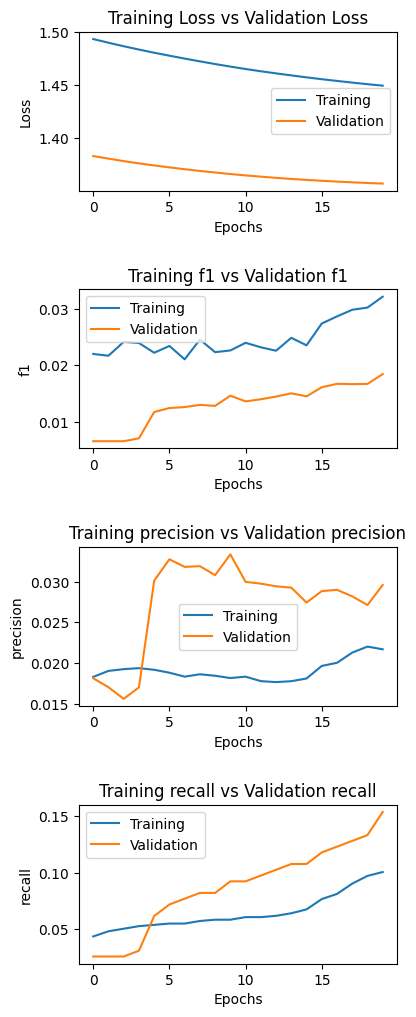

In [679]:
print('baseline')
plot_train_val_loss(histories[0])

convolution


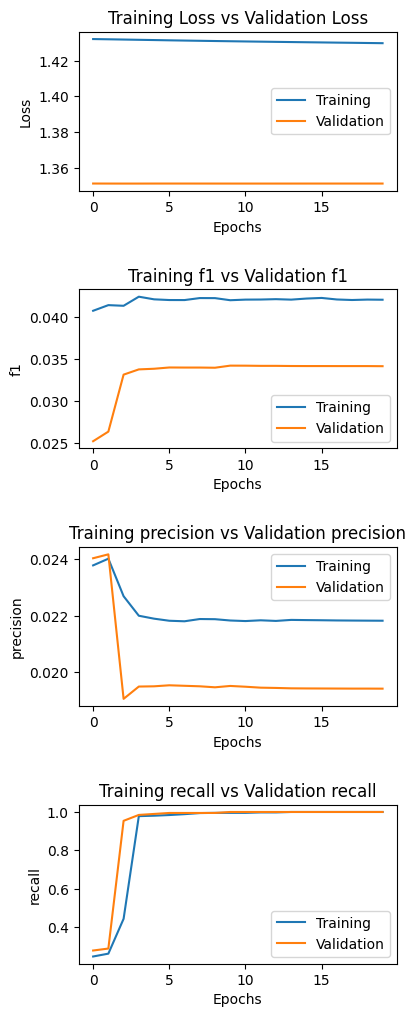

In [680]:
print('convolution')
plot_train_val_loss(histories[1])

In [660]:
histories[0].history

{'loss': [1.1866782903671265,
  1.1750051975250244,
  1.1648834943771362,
  1.1562165021896362,
  1.1488308906555176,
  1.1425142288208008,
  1.1372050046920776,
  1.1327370405197144,
  1.1289267539978027,
  1.125713586807251,
  1.1229803562164307,
  1.1206495761871338,
  1.1186327934265137,
  1.1168584823608398,
  1.115287184715271,
  1.1138875484466553,
  1.11263906955719,
  1.111494541168213,
  1.1104432344436646,
  1.1094961166381836],
 'acc': [0.7387048602104187,
  0.7438107132911682,
  0.7502615451812744,
  0.7569364905357361,
  0.763835608959198,
  0.772503137588501,
  0.7806974053382874,
  0.7904358506202698,
  0.7997010946273804,
  0.8107098340988159,
  0.8215193152427673,
  0.8345454335212708,
  0.8471481800079346,
  0.8582316040992737,
  0.8696637749671936,
  0.8782814741134644,
  0.887397289276123,
  0.8954172134399414,
  0.9026151895523071,
  0.9084682464599609],
 'auc': [0.5073779225349426,
  0.49731650948524475,
  0.5046485066413879,
  0.5029116272926331,
  0.50310665369

393/393 [==============================] - 0s 872us/step


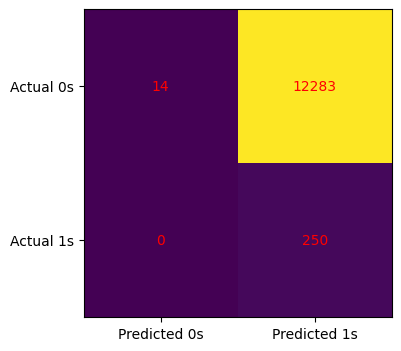

In [685]:
confusion_matrix_plot(model_list[1])

In [87]:
%%time
input_data_ = input_data[['CHL', 'riskLevelLabel', 'site', 'time']]

xy_data = get_train_test_val_nn(input_data_, 
                           time_site_pairs_train, 
                           time_site_pairs_test, 
                           oversampling = False)

history, result = fit_nn(xy_data, "baseline")

111/111 [==============================] - 0s 925us/step - loss: 0.1039 - acc: 0.9749 - auc: 0.7555 - precision: 0.1923 - recall: 0.0685 - f1: 0.0336         
CPU times: user 15.4 s, sys: 2.7 s, total: 18.1 s
Wall time: 12.6 s


In [686]:
%%time

from keras.optimizers import Adam
import itertools
from IPython.display import clear_output

model_types = ["convolution"]
num_features = [1]
oversampling_ = [False]

model_list = []
i = 0

loss_weights = np.arange(10,100,5)

for loss_weight in loss_weights:
    
    model_type, num_feature, oversampling__ = "convolution", 1, False
    
    # Getting Input Data
    if num_feature == 1:
        input_data_ = input_data[['CHL', 'riskLevelLabel', 'site', 'time']]
        
    elif num_feature == 3:
        input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]
    
    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_, 
                           time_site_pairs_train, 
                           time_site_pairs_test, 
                           oversampling = oversampling__)
    
    # Get history and result
    model_, history, result = fit_nn(xy_data, model_type, loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=0.00001))
    model_list.append(model_)
    histories.append(history)
    results.append(result)
    
    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/{len(loss_weights)}')
    print(datetime.now())



Progress: 18/18
2023-05-19 19:20:22.525230
CPU times: user 46min 1s, sys: 3min 59s, total: 50min
Wall time: 12min 2s


393/393 [==============================] - 0s 954us/step


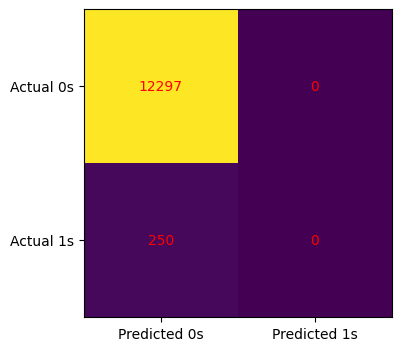

393/393 [==============================] - 0s 1ms/step


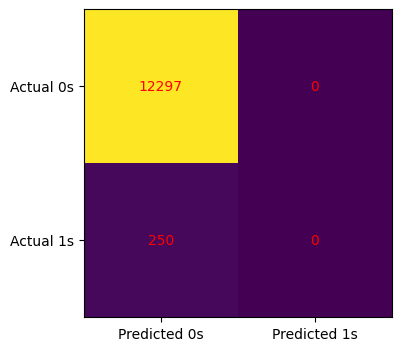

393/393 [==============================] - 0s 1ms/step


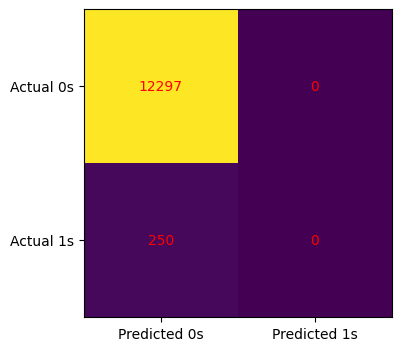

393/393 [==============================] - 0s 1ms/step


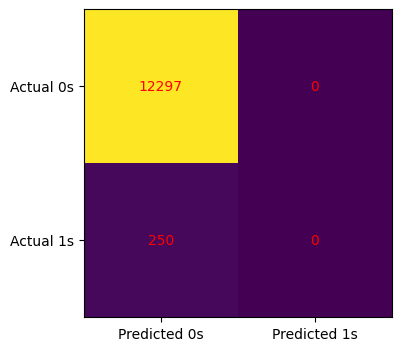

393/393 [==============================] - 0s 968us/step


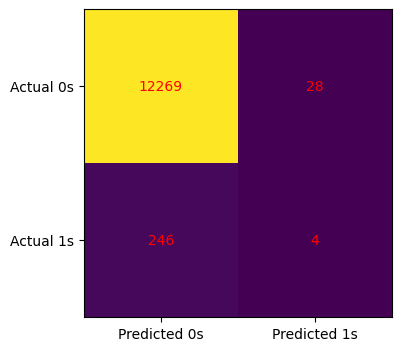

393/393 [==============================] - 0s 1ms/step


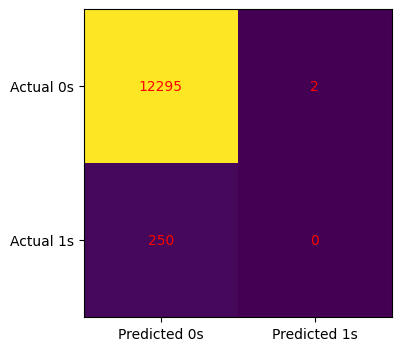

393/393 [==============================] - 0s 950us/step


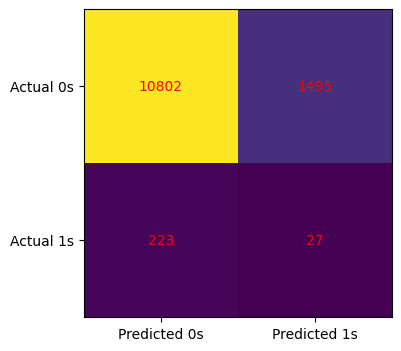

393/393 [==============================] - 0s 1ms/step


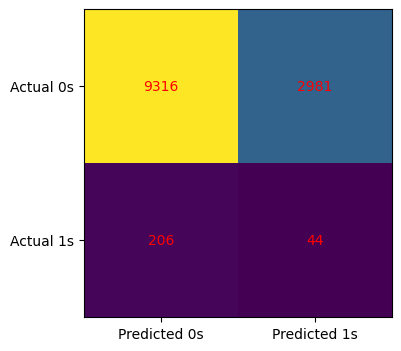

393/393 [==============================] - 0s 1ms/step


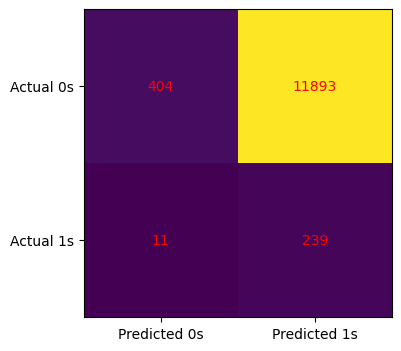

393/393 [==============================] - 0s 976us/step


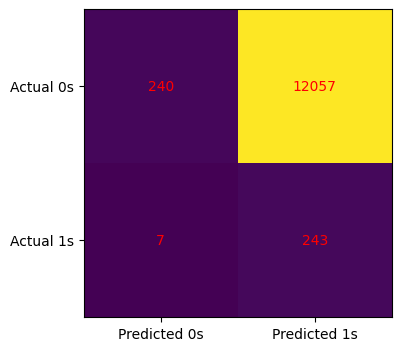

393/393 [==============================] - 0s 955us/step


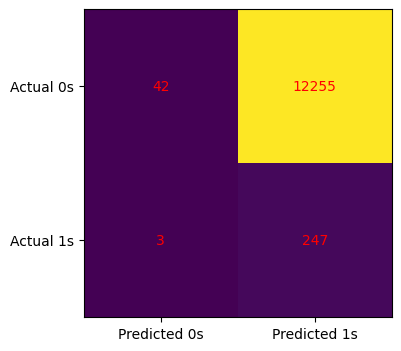

393/393 [==============================] - 0s 949us/step


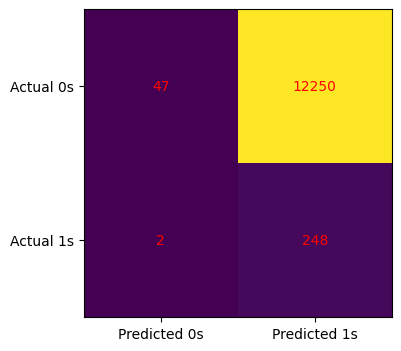

393/393 [==============================] - 0s 991us/step


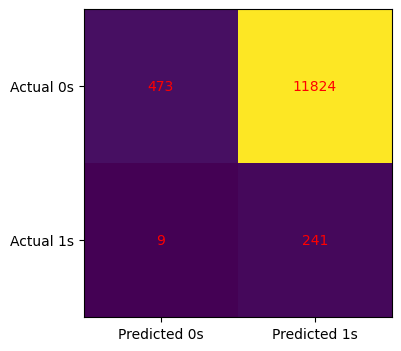

393/393 [==============================] - 0s 964us/step


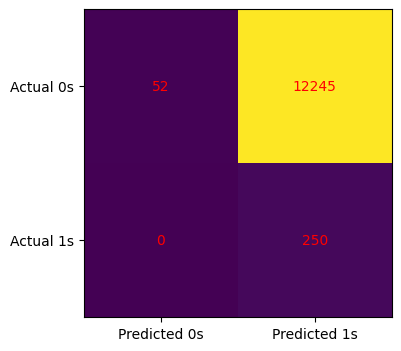

393/393 [==============================] - 0s 1ms/step


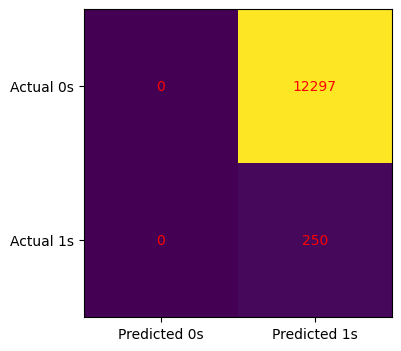

393/393 [==============================] - 0s 989us/step


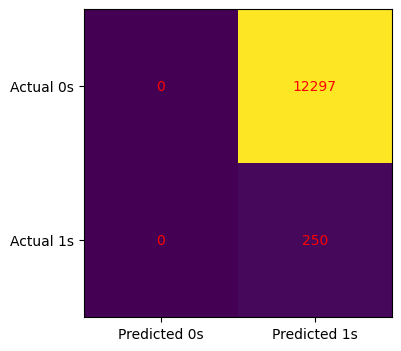

393/393 [==============================] - 0s 990us/step


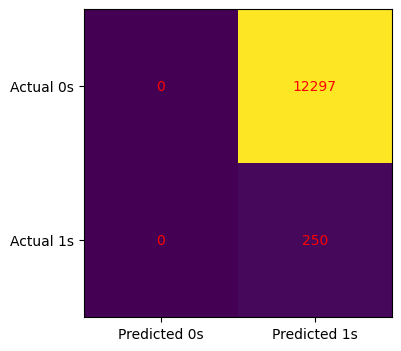

393/393 [==============================] - 0s 991us/step


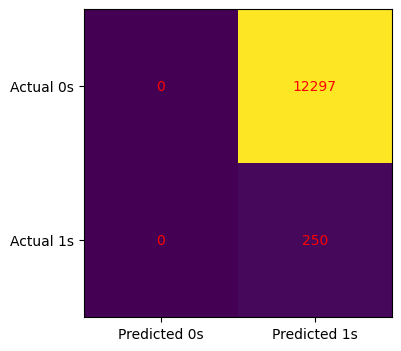

In [692]:
# best seems to be with weight1=50?

for i in np.arange(18):
    confusion_matrix_plot(model_list[i])

In [39]:
# %%time
# fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(25, 50))

# for i, ax in enumerate(axs.flatten()):
#     if i <= 18:
#         confusion_matrix_plot(model_list[-18:][i])
#         plt.sca(ax)
#         plt.xticks([])
#         plt.yticks([])
        
#     else:
#         ax.axis('off')
        
# plt.subplots_adjust(wspace=0.2, hspace=0.6)
# plt.show()

In [69]:
# def get_train_test_val(input_data, desired_pos_ratio =  0.5, train_test_ratio = 0.8, train_val_ratio = 0.8):
#     '''
#     input: 
#         - input_data (pd.DataFrame): 
#             - dataframe of shape (m, n)
#             - number of datapoints = m
#             - features to consider = n-1
#             - one of the columns = 'riskLevelLabel'

#         - desired_pos_ratio (float):
#             - desired ratio of positive samples when performing random oversampling

#         - train_test_ratio (float):
#             - ratio of training data to testing data

#         - train_val_ratio (float):
#             - ratio of training data to validation data
            
#     output:
#         - X_train (tensor)
#         - X_test (tensor)
#         - X_val (tensor)
#         - y_train (np.array)
#         - y_test (np.array)
#         - y_val (np.array)
    
#     '''
    
#     # Getting X and y
#     features_column_names = list(input_data.columns)
#     features_column_names.remove('riskLevelLabel')
#     X = input_data[features_column_names]
#     y = np.array([1 if x == 'increased' else 0 for x in input_data['riskLevelLabel']])
    
#     # Counting number of samples to oversample
#     num_positives, num_negatives = sum(y), len(y)-sum(y)
#     num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives
    
#     # Oversampling
#     ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
#     X, y = ros.fit_resample(X, y)
    
#     # Reshape and Convert to Tensor
#     if X.shape[1] == 1: 
#         X = np.array([i for i in X[features_column_names[0]]])
#         X = tf.convert_to_tensor(X)
#         X = tf.expand_dims(X, axis=3, name=None)
#     else:
#         X = np.stack([np.stack(X[col].values) for col in X.columns], axis=1)
#         X = np.transpose(X, (0, 2, 3, 1))
#         X = tf.convert_to_tensor(X)
    
#     # Reshape to 32x32 with simple padding for model input
#     X = tf.pad(X, [[0, 0], [11,10], [11,10], [0,0]])
    
#     # Train Test Split
#     i = int(X.shape[0] * train_test_ratio)
#     X_train, y_train = X[:i], y[:i]
#     X_test, y_test = X[i:], y[i:]

#     # Train Validation Split
#     i = int(X.shape[0] * train_test_ratio * train_val_ratio)
#     X_val, y_val = X_train[i:], y_train[i:]
#     X_train, y_train = X_train[:i], y_train[:i]

#     return X_train, X_test, X_val, y_train, y_test, y_val

In [70]:
X = input_data[['CHL']]
X.columns[0]
# X = np.array([i for i in X])
# X = tf.convert_to_tensor(X)
# X = tf.expand_dims(X, axis=3, name=None)

'CHL'

In [15]:
X = input_data[['CHL']]
np.array([i for i in X['CHL']]).shape

(17777, 11, 11)

# Model Architecture

## Baseline (No Convolution)

In [147]:
model_b = models.Sequential()
model_b.add(layers.Flatten(input_shape=X_train.shape[1:]))
model_b.add(layers.Dense(100, activation='relu'))
model_b.add(layers.Dense(1, activation="sigmoid"))

# model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
# model_b.add(layers.Flatten())
# model_b.add(layers.Dense(120, activation='relu')),
# model_b.add(layers.Dense(84, activation='relu')),
# model_b.add(layers.Dense(10, activation='relu')),
# model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 100)               102500    
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [166]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["AUC"])

## Convolution

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

# Training and Results

## Plotting Function

In [138]:
def plot_train_val_loss(his, metric):
    '''
    input:
        - history
        - metric (acc/f1)
    output: 2 graphs
    '''
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    axs[0].plot(his.history['loss'])
    axs[0].plot(his.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])
    axs[1].plot(his.history[f'{metric}'])
    axs[1].plot(his.history[f'val_{metric}'])
    axs[1].title.set_text(f'Training {metric} vs Validation {metric}')
    axs[1].legend(['Training', 'Validation'])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel(f"{metric}")

## Defining F1 Metric

In [134]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Baseline, 1 feature (CHL)

### Data

In [124]:
input_data_ = input_data_1.drop(['Unnamed: 0', 'Site Name in Files'], axis=1)
input_data_ = input_data_[['CHL', 'riskLevelLabel', 'site', 'time']]

In [125]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, time_site_pairs_train, time_site_pairs_test)

In [157]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, time_site_pairs_train, time_site_pairs_test, oversampling = False)

In [158]:
X_train.shape

TensorShape([11377, 32, 32, 1])

### Model

In [161]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_11 (Avera  (None, 16, 16, 1)        0         
 gePooling2D)                                                    
                                                                 
 flatten_14 (Flatten)        (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 120)               30840     
                                                                 
 dense_45 (Dense)            (None, 84)                10164     
                                                                 
 dense_46 (Dense)            (None, 10)                850       
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                     

In [167]:
opt = 'adam'
# model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["AUC"])

In [168]:
history_b = model_b.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
178/178 [==============================] - 1s 2ms/step - loss: 0.0654 - auc: 0.9326 - val_loss: 0.2234 - val_auc: 0.5110
Epoch 2/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0626 - auc: 0.9431 - val_loss: 0.2033 - val_auc: 0.5143
Epoch 3/40
178/178 [==============================] - 0s 2ms/step - loss: 0.0641 - auc: 0.9414 - val_loss: 0.2135 - val_auc: 0.5155
Epoch 4/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0626 - auc: 0.9439 - val_loss: 0.2110 - val_auc: 0.5367
Epoch 5/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0629 - auc: 0.9411 - val_loss: 0.2064 - val_auc: 0.5260
Epoch 6/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0617 - auc: 0.9457 - val_loss: 0.1949 - val_auc: 0.5565
Epoch 7/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0610 - auc: 0.9535 - val_loss: 0.2115 - val_auc: 0.5323
Epoch 8/40
178/178 [==============================] - 0s 1ms/step - loss: 0.

In [164]:
history_b.history['f1']

[0.0,
 0.0,
 0.0,
 0.007490635383874178,
 0.024344565346837044,
 0.026217224076390266,
 0.014981270767748356,
 0.04138576611876488,
 0.024344567209482193,
 0.036142315715551376,
 0.03651684895157814,
 0.039807382971048355,
 0.06573033332824707,
 0.05599250644445419,
 0.05617976933717728,
 0.09026216715574265,
 0.06348314136266708,
 0.07153557986021042,
 0.10430710017681122,
 0.08071160316467285,
 0.09868913143873215,
 0.08623595535755157,
 0.0859818160533905,
 0.10099873691797256,
 0.0938202291727066,
 0.10639379173517227,
 0.09681648015975952,
 0.09082396328449249,
 0.1092696562409401,
 0.11123596131801605,
 0.09737826883792877,
 0.09438201785087585,
 0.10945692658424377,
 0.09272338449954987,
 0.09400749206542969,
 0.11382362246513367,
 0.1308988630771637,
 0.1086142286658287,
 0.1213482916355133,
 0.14063668251037598]

KeyError: 'f1'

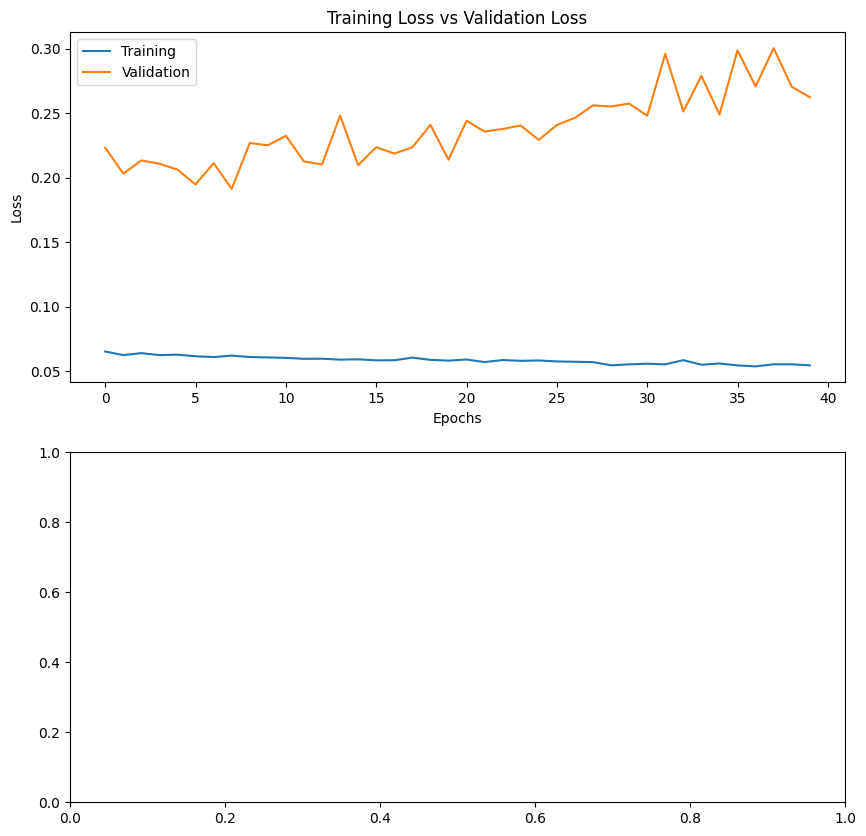

In [169]:
plot_train_val_loss(history_b, 'f1')

In [145]:
result_b_1 = model_b.evaluate(X_test, y_test)
result_b_1

112/112 [==============================] - 0s 534us/step - loss: 0.2562 - f1: 0.2031


[0.25621452927589417, 0.2030753791332245]

## Convolution, 1 feature (CHL)

### Model

In [103]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_5 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_6 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 576)               0         
                                                                 
 dense_16 (Dense)            (None, 120)              

In [104]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [105]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 3s 9ms/step - loss: 0.5327 - acc: 0.7361 - val_loss: 0.6076 - val_acc: 0.6795
Epoch 2/40
344/344 [==============================] - 3s 8ms/step - loss: 0.3603 - acc: 0.8390 - val_loss: 0.3896 - val_acc: 0.8570
Epoch 3/40
344/344 [==============================] - 3s 9ms/step - loss: 0.2758 - acc: 0.8836 - val_loss: 0.4966 - val_acc: 0.7585
Epoch 4/40
344/344 [==============================] - 3s 9ms/step - loss: 0.2297 - acc: 0.9058 - val_loss: 0.2087 - val_acc: 0.9598
Epoch 5/40
344/344 [==============================] - 3s 9ms/step - loss: 0.2035 - acc: 0.9199 - val_loss: 0.2254 - val_acc: 0.9458
Epoch 6/40
344/344 [==============================] - 3s 9ms/step - loss: 0.1902 - acc: 0.9246 - val_loss: 0.1528 - val_acc: 0.9800
Epoch 7/40
344/344 [==============================] - 3s 9ms/step - loss: 0.1771 - acc: 0.9310 - val_loss: 0.1928 - val_acc: 0.9622
Epoch 8/40
344/344 [==============================] - 3s 9ms/step - loss: 0.

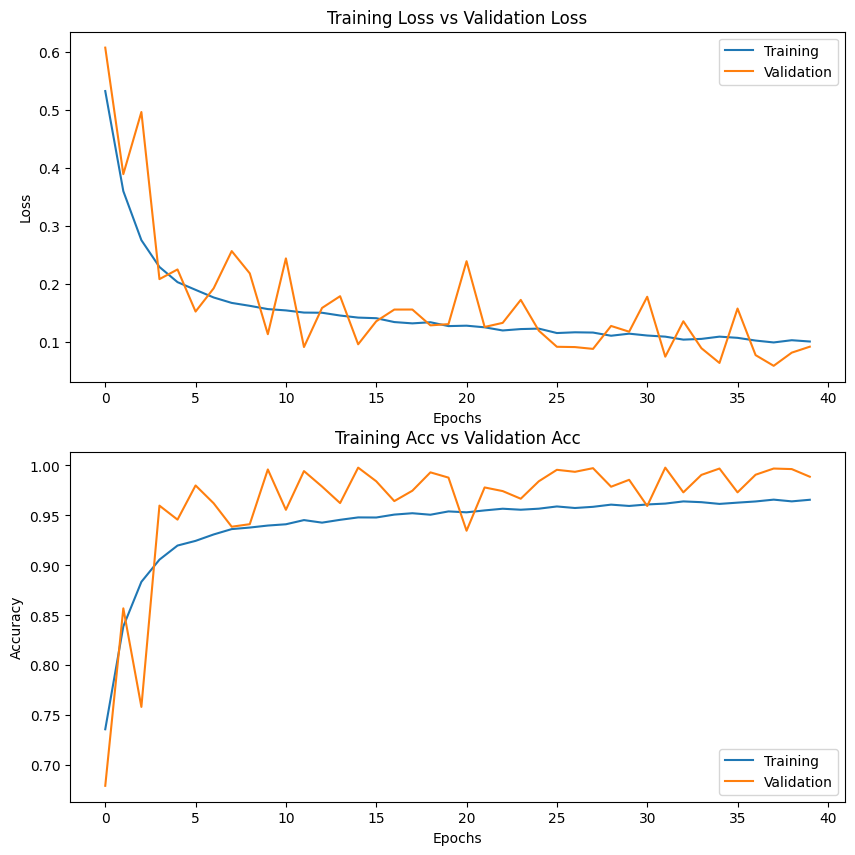

In [106]:
plot_train_val_loss_acc(history)

In [107]:
result_c_1 = model.evaluate(X_test, y_test)
result_c_1

112/112 [==============================] - 0s 2ms/step - loss: 0.2222 - acc: 0.9440


[0.2222413271665573, 0.9440224766731262]

## Baseline, 3 features

### Data

In [108]:
input_data_ = input_data_1.drop(['Unnamed: 0', 'Site Name in Files'], axis=1)
input_data_

,time,TUR,SPM,CHL,site,riskLevelLabel
1,2022-04-29,"[[0.0, 0.0, 0.0, 0.0, 6.66657, 17.572878, 10.8...","[[0.0, 0.0, 0.0, 0.0, 3.965849, 10.934258, 7.0...","[[0.0, 0.0, 0.0, 0.0, 3.342492, 8.107634, 9.17...",Seaton Carew North,normal
3,2022-05-04,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",Seaton Carew North,normal
13,2022-05-14,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",Seaton Carew North,normal
15,2022-05-16,"[[0.0, 0.0, 0.0, 7.8827524, 4.909162, 7.495511...","[[0.0, 0.0, 0.0, 4.6897936, 3.0189908, 4.60904...","[[0.0, 0.0, 0.0, 5.1706023, 4.0242176, 15.5288...",Seaton Carew North,increased
18,2022-05-19,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",Seaton Carew North,normal
...,...,...,...,...,...,...
63634,2022-09-19,"[[7.055306, 11.538847, 21.925156, 38.97817, 67...","[[4.1807566, 6.9168806, 13.601273, 25.838427, ...","[[9.039883, 9.1092415, 8.58365, 8.242571, 1.83...",Westward Ho!,normal
63636,2022-09-21,"[[7.0546794, 11.46094, 21.594828, 37.921295, 6...","[[4.1956024, 6.904963, 13.490634, 25.326557, 4...","[[9.529826, 9.603931, 8.9767, 8.631461, 1.8302...",Westward Ho!,normal
63639,2022-09-24,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",Westward Ho!,normal
63641,2022-09-26,"[[12.430533, 17.521309, 27.909481, 32.5058, 90...","[[7.6267166, 10.912169, 18.30988, 21.522917, 6...","[[11.114327, 11.215534, 10.675369, 10.119238, ...",Westward Ho!,normal


In [109]:
%%time
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, time_site_pairs_train, time_site_pairs_test)

CPU times: user 210 ms, sys: 186 ms, total: 396 ms
Wall time: 311 ms


### Model

In [110]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_7 (Averag  (None, 16, 16, 3)        0         
 ePooling2D)                                                     
                                                                 
 flatten_5 (Flatten)         (None, 768)               0         
                                                                 
 dense_20 (Dense)            (None, 120)               92280     
                                                                 
 dense_21 (Dense)            (None, 84)                10164     
                                                                 
 dense_22 (Dense)            (None, 10)                850       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                      

In [111]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [112]:
history_b = model_b.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 1s 2ms/step - loss: 0.5084 - acc: 0.7722 - val_loss: 0.4887 - val_acc: 0.7113
Epoch 2/40
344/344 [==============================] - 1s 2ms/step - loss: 0.3367 - acc: 0.8576 - val_loss: 0.3690 - val_acc: 0.8449
Epoch 3/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2709 - acc: 0.8856 - val_loss: 0.2975 - val_acc: 0.8860
Epoch 4/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2318 - acc: 0.9085 - val_loss: 0.3225 - val_acc: 0.8660
Epoch 5/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2121 - acc: 0.9146 - val_loss: 0.2198 - val_acc: 0.9320
Epoch 6/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2051 - acc: 0.9215 - val_loss: 0.3016 - val_acc: 0.8823
Epoch 7/40
344/344 [==============================] - 1s 2ms/step - loss: 0.1868 - acc: 0.9301 - val_loss: 0.2256 - val_acc: 0.9274
Epoch 8/40
344/344 [==============================] - 1s 2ms/step - loss: 0.

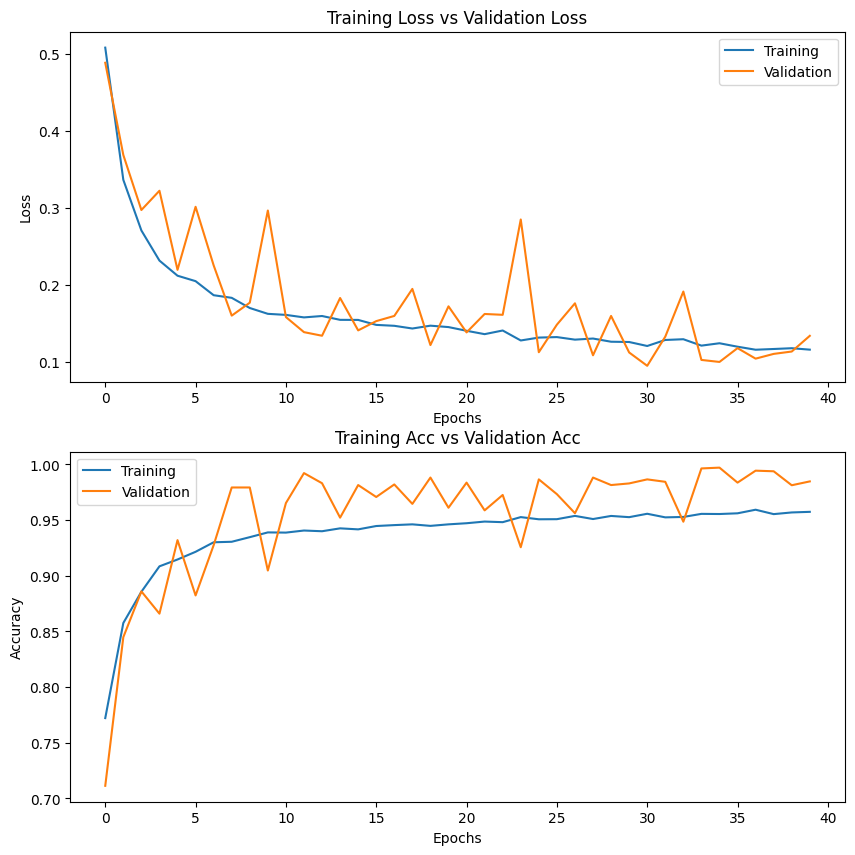

In [113]:
plot_train_val_loss_acc(history_b)

In [114]:
result_b_3 = model_b.evaluate(X_test, y_test)
result_b_3

112/112 [==============================] - 0s 831us/step - loss: 0.2618 - acc: 0.9376


[0.2617828845977783, 0.9375527501106262]

## Convolution, 3 features

### Model

In [115]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_8 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_9 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_6 (Flatten)         (None, 576)               0         
                                                                 
 dense_24 (Dense)            (None, 120)              

In [116]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [117]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 4s 11ms/step - loss: 0.5198 - acc: 0.7475 - val_loss: 0.6033 - val_acc: 0.7159
Epoch 2/40
344/344 [==============================] - 4s 11ms/step - loss: 0.3284 - acc: 0.8530 - val_loss: 0.2721 - val_acc: 0.9194
Epoch 3/40
344/344 [==============================] - 4s 11ms/step - loss: 0.2433 - acc: 0.8991 - val_loss: 0.2777 - val_acc: 0.9223
Epoch 4/40
344/344 [==============================] - 4s 11ms/step - loss: 0.2024 - acc: 0.9190 - val_loss: 0.1921 - val_acc: 0.9734
Epoch 5/40
344/344 [==============================] - 4s 11ms/step - loss: 0.1811 - acc: 0.9300 - val_loss: 0.1633 - val_acc: 0.9722
Epoch 6/40
344/344 [==============================] - 4s 11ms/step - loss: 0.1681 - acc: 0.9358 - val_loss: 0.2235 - val_acc: 0.9329
Epoch 7/40
344/344 [==============================] - 4s 11ms/step - loss: 0.1635 - acc: 0.9382 - val_loss: 0.2352 - val_acc: 0.9382
Epoch 8/40
344/344 [==============================] - 4s 12ms/step - 

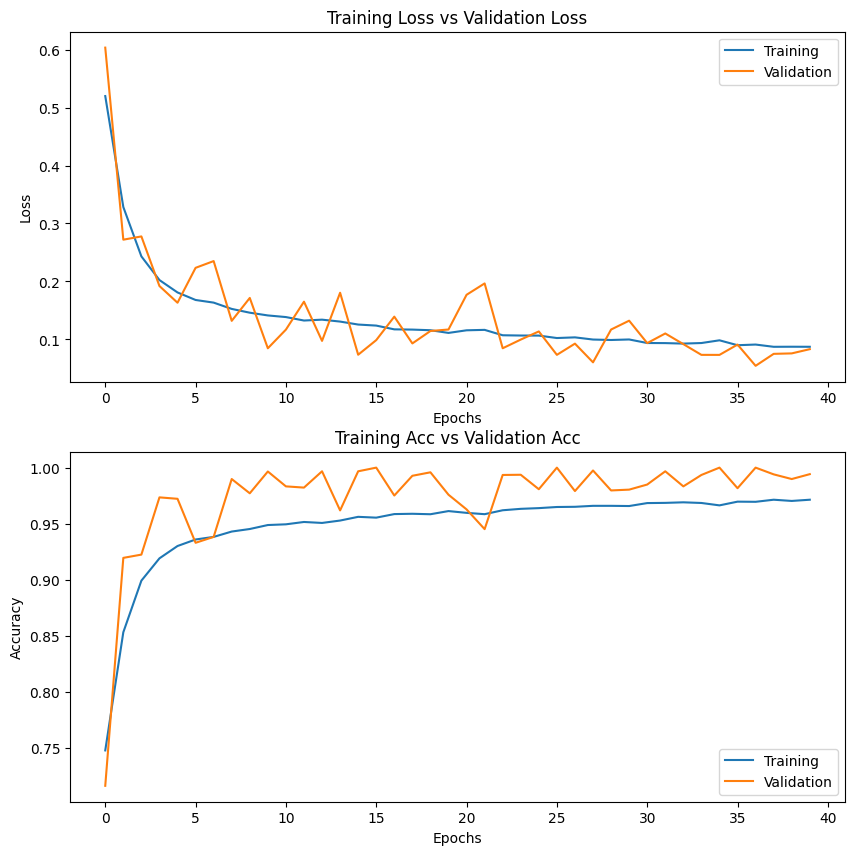

In [118]:
plot_train_val_loss_acc(history)

In [119]:
result_c_3 = model.evaluate(X_test, y_test)
result_c_3

112/112 [==============================] - 0s 2ms/step - loss: 0.3361 - acc: 0.9440


[0.33608847856521606, 0.9440224766731262]

### Result Summary

In [121]:
print('Baseline 1 Feature (CHL):', result_b_1)
print('Convolution 1 Feature (CHL):', result_c_1)
print('Baseline 3 Features:', result_b_3)
print('Convolution 3 Features:', result_c_3)

Baseline 1 Feature (CHL): [0.22234012186527252, 0.9327707290649414]
Convolution 1 Feature (CHL): [0.2222413271665573, 0.9440224766731262]
Baseline 3 Features: [0.2617828845977783, 0.9375527501106262]
Convolution 3 Features: [0.33608847856521606, 0.9440224766731262]


In [301]:
# xy_data = get_train_test_val_nn(input_data_, 
#                        time_site_pairs_train, 
#                        time_site_pairs_test, 
#                        oversampling = oversampling__)

# y_train = xy_data['y_train']

# weights = class_weight.compute_class_weight(class_weight='balanced',
#                                             classes=np.unique(y_train),
#                                             y=y_train)

# weights